In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [48]:
# importing standard libraries
import amp_pd_peptide

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.simplefilter(action='ignore')

In [49]:
# getting csv files

# training data
train = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")
sup = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv')
train = train.append(sup, ignore_index=True)

# sample submission
sample_submission = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/sample_submission.csv')

# test data
test = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test.csv')
test_peptides = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_peptides.csv')
test_proteins = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_proteins.csv')

In [50]:
train.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [51]:
test.head()

,visit_id,visit_month,patient_id,updrs_test,row_id,group_key
0,3342_0,0,3342,updrs_1,3342_0_updrs_1,0
1,3342_0,0,3342,updrs_2,3342_0_updrs_2,0
2,3342_0,0,3342,updrs_3,3342_0_updrs_3,0
3,3342_0,0,3342,updrs_4,3342_0_updrs_4,0
4,50423_0,0,50423,updrs_1,50423_0_updrs_1,0


In [52]:
# getting unique months
test['visit_month'].unique()

array([0, 6])

In [53]:
test_peptides.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,group_key
0,50423_0,0,50423,O00391,AHFSPSNIILDFPAAGSAAR,22226.3,0
1,50423_0,0,50423,O00391,NEQEQPLGQWHLS,10901.6,0
2,50423_0,0,50423,O00533,GNPEPTFSWTK,51499.4,0
3,50423_0,0,50423,O00533,IEIPSSVQQVPTIIK,125492.0,0
4,50423_0,0,50423,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,23174.2,0


In [54]:
test_proteins.head()

,visit_id,visit_month,patient_id,UniProt,NPX,group_key
0,50423_0,0,50423,O00391,33127.90,0
1,50423_0,0,50423,O00533,490742.00,0
2,50423_0,0,50423,O00584,43615.30,0
3,50423_0,0,50423,O14773,16486.60,0
4,50423_0,0,50423,O14791,2882.42,0


In [55]:
sample_submission.head(20)

,prediction_id,rating,group_key
0,3342_0_updrs_1_plus_0_months,0,0
1,3342_0_updrs_1_plus_6_months,0,0
2,3342_0_updrs_1_plus_12_months,0,0
3,3342_0_updrs_1_plus_24_months,0,0
4,3342_0_updrs_2_plus_0_months,0,0
5,3342_0_updrs_2_plus_6_months,0,0
6,3342_0_updrs_2_plus_12_months,0,0
7,3342_0_updrs_2_plus_24_months,0,0
8,3342_0_updrs_3_plus_0_months,0,0
9,3342_0_updrs_3_plus_6_months,0,0


In [56]:
# getting na values
train.isna().sum()

visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                 214
updrs_2                                 216
updrs_3                                  30
updrs_4                                1966
upd23b_clinical_state_on_medication    2428
dtype: int64

In [57]:
test.isna().sum()

visit_id       0
visit_month    0
patient_id     0
updrs_test     0
row_id         0
group_key      0
dtype: int64

In [58]:
test_proteins.isna().sum()

visit_id       0
visit_month    0
patient_id     0
UniProt        0
NPX            0
group_key      0
dtype: int64

In [59]:
test_proteins.isna().sum()

visit_id       0
visit_month    0
patient_id     0
UniProt        0
NPX            0
group_key      0
dtype: int64

<AxesSubplot:xlabel='updrs_4'>

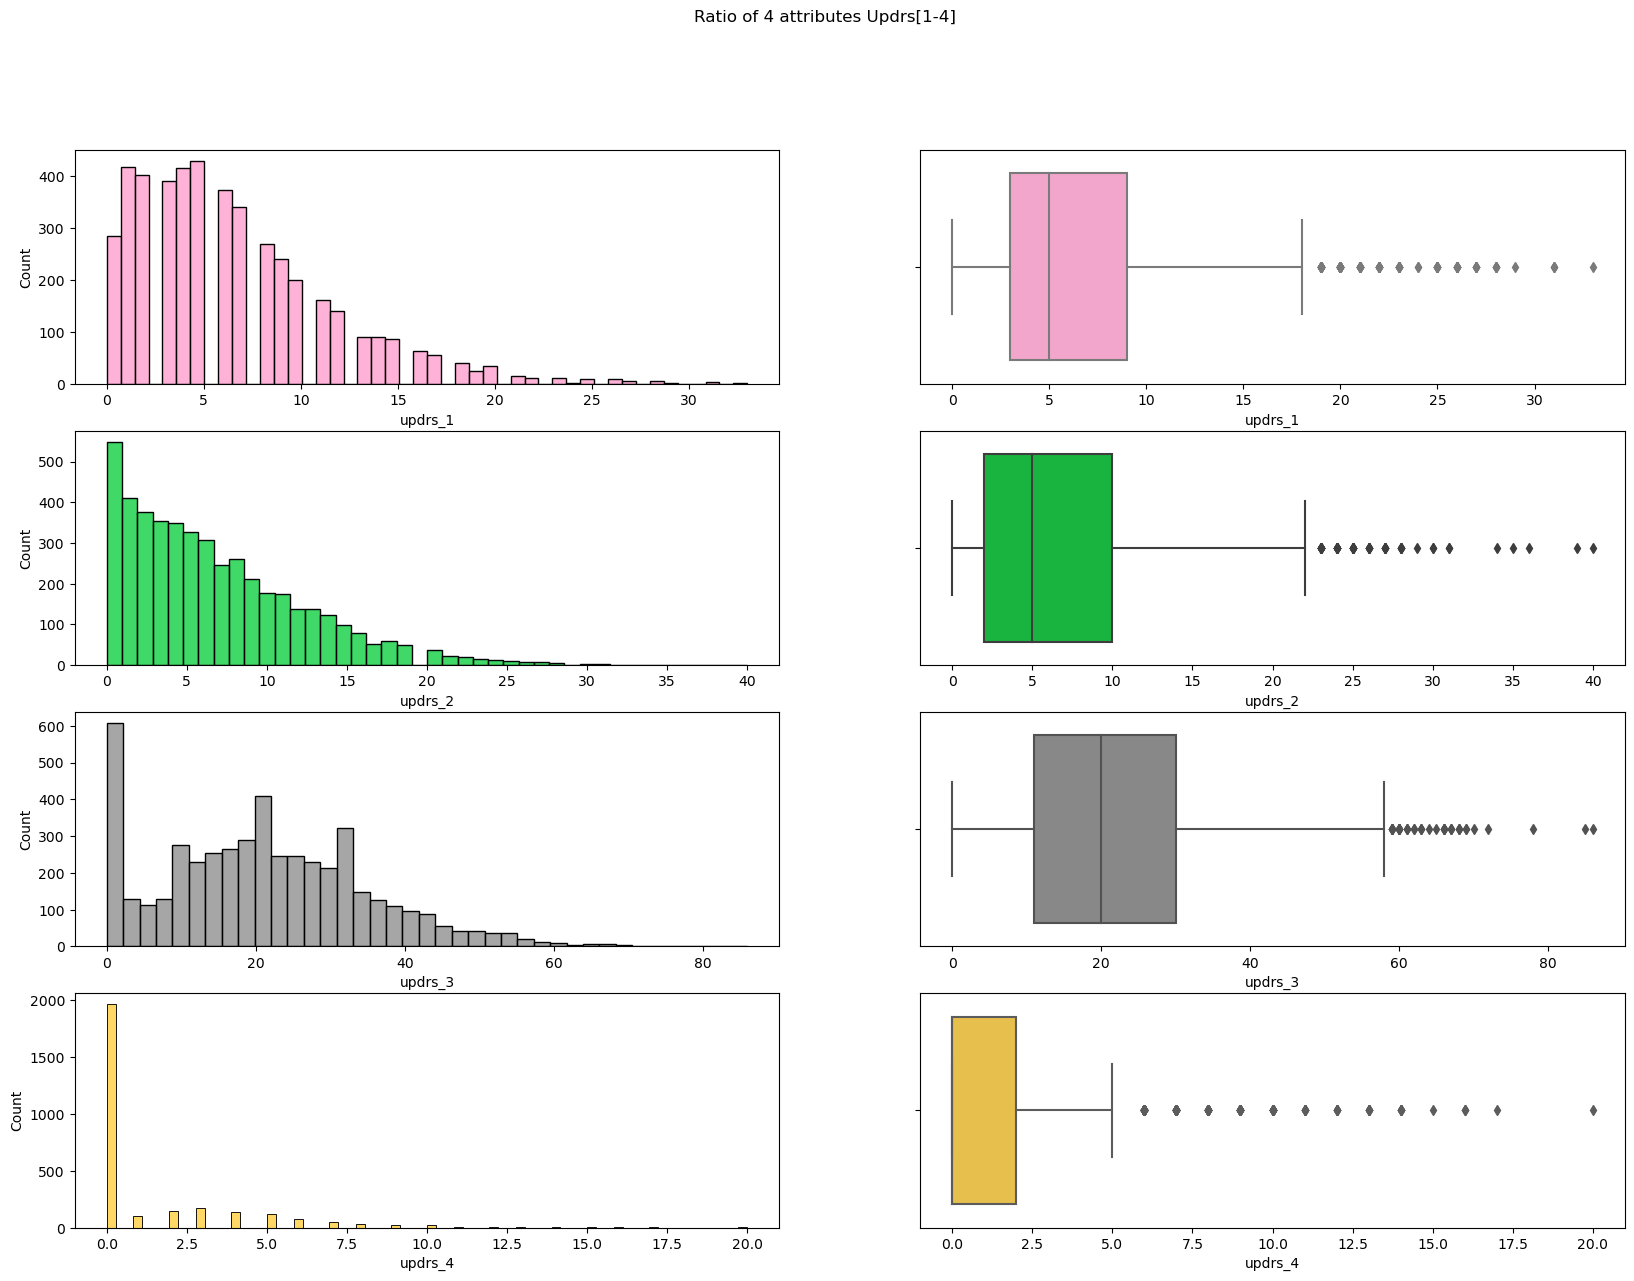

In [60]:
# Seeing relation of dataset with updrs
fig, axes = plt.subplots(4,2 , figsize=(20, 14))
fig.suptitle('Ratio of 4 attributes Updrs[1-4]')
sns.histplot(ax=axes[0, 0],data=train, x="updrs_1",color ="#FF99CC")
sns.boxplot(ax=axes[0,1],x=train["updrs_1"],color = "#FF99CC")

sns.histplot(ax=axes[1, 0],data=train, x="updrs_2",color ="#00CC33")
sns.boxplot(ax=axes[1, 1],x=train["updrs_2"],color ="#00CC33")

sns.histplot(ax=axes[2, 0],data=train, x="updrs_3",color ="#888888")
sns.boxplot(ax=axes[2,1],x=train["updrs_3"],color = "#888888")

sns.histplot(ax=axes[3, 0],data=train, x="updrs_4",color ="#FFCC33")
sns.boxplot(ax=axes[3,1],x=train["updrs_4"],color = "#FFCC33")

In [61]:
# Training
# Applying model
model = {}

# initializing targets
target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

Y = []

for u in target:
    i = 0
    j = 0
    # Drop NAs
    temp = train.dropna(subset=[u]) 
    
    # For updrs_3, dropping 0's improve results
    if u == 'updrs_3':
        temp = temp[temp[u] != 0]
    
    # Train data
    X = temp['visit_month']
    y = temp[u]
    Y.append(y)
    
    X = X.values.reshape(-1, 1)
    
    #print(X)
    #print(y)    
    
    
    # Linear Regression
    model_trained = LinearRegression().fit(X, y)
    
    # Random Forest Regression
    # model_trained = RandomForestRegressor(max_depth=5, random_state=0).fit(X, y)
    
        
    # Save the trained model in the variable model
    model[u] = model_trained

In [62]:
# Function to compute the prediction 

def get_predictions(df, model):

    # Forecast
    df = df.fillna(0)
    
    for u in target:
        
        # Here is where we will save the final results
        df['result_' + str(u)] = 0
  
        # Predict    
        X = df["visit_month"]
        X = X.values.reshape(-1, 1)
        
        # updrs_4 will have only 0's, so we update for others
        if u != 'updrs_4':
            df['result_' + str(u)] = model[u].predict(X)
        #df['True_y'] = df[u]

        
    # Format for final submission
    result = pd.DataFrame()

    for m in [0, 6, 12, 24]:
        for u in [1, 2, 3, 4]:

            temp = df[["visit_id", "result_updrs_" + str(u)]]
            temp["prediction_id"] = temp["visit_id"] + "_updrs_" + str(u) + "_plus_" + str(m) + "_months"
            temp["rating"] = temp["result_updrs_" + str(u)]
            temp = temp [['prediction_id', 'rating']]

            result = result.append(temp)            
    result = result.drop_duplicates(subset=['prediction_id', 'rating'])

    return result

# Run once to check results
result = get_predictions(train, model)


In [63]:
# SMAPE Prediction
def calculate_smape(actual, predicted):
  
    # Convert actual and predicted to numpy
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
  
    return round(np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2))*100, 2)

In [64]:
# Testing
env = amp_pd_peptide.make_env()
amp_pd_peptide.make_env.func_dict['__called__'] = False
iter_test = env.iter_test()

for (test, test_peptides, test_proteins, sample_submission) in iter_test:
    
    print(1)
        
    result = get_predictions(test, model)
    print(result.head())
    env.predict(result)  

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
1
                   prediction_id     rating
0   3342_0_updrs_1_plus_0_months   5.702817
4  50423_0_updrs_1_plus_0_months   5.702817
0   3342_0_updrs_2_plus_0_months   5.957276
4  50423_0_updrs_2_plus_0_months   5.957276
0   3342_0_updrs_3_plus_0_months  21.490644
1
                   prediction_id     rating
0   3342_6_updrs_1_plus_0_months   5.902148
4  50423_6_updrs_1_plus_0_months   5.902148
0   3342_6_updrs_2_plus_0_months   6.130305
4  50423_6_updrs_2_plus_0_months   6.130305
0   3342_6_updrs_3_plus_0_months  21.836443
